In [109]:
import torch
import gzip
import csv
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pack_padded_sequence
import time
import math

In [151]:
HIDDEN_SIZE = 100
BATCH_SIZE = 256
N_LAYER = 2
N_EPOCHS = 500
N_CHARS = 128
USE_GPU = False

In [153]:
class NameDataset(Dataset):
    def __init__(self, is_train_set=True):
        filename = 'names_train.csv.gz' if is_train_set else 'names_test.csv.gz'
        with gzip.open(filename, 'rt') as f:
            reader = csv.reader(f)
            rows = list(reader)
        self.names = [row[0] for row in rows]
        self.len = len(self.names)
        self.countries = [row[1] for row in rows]
        self.country_list = list(sorted(set(self.countries)))
        self.country_dict = self.getCountryDict()
        self.country_num = len(self.country_list)

    def __getitem__(self, index):
        return self.names[index], self.country_dict[self.countries[index]]

    def __len__(self):
        return self.len
    def getCountryDict(self):
        country_dict = dict()
        for idx, country_name in enumerate(self.country_list, 0):
            country_dict[country_name] = idx
        return country_dict

    def idx2country(self, index):
        return self.country_list[index]
    def getCountriesNum(self):
        return self.country_num

In [155]:
trainset = NameDataset(is_train_set=True)
trainloader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True)

testset = NameDataset(is_train_set=False)
testloader = DataLoader(testset, batch_size=BATCH_SIZE, shuffle=False)

N_COUNTRY = trainset.getCountriesNum()

In [157]:
class RNNClassifier(torch.nn.Module):
    def __init__(self, input_size, hidden_size, output_size, n_layers=1, bidirectional=True):
        super(RNNClassifier, self).__init__()
        self.hidden_size = hidden_size
        self.n_layers = n_layers
        self.n_directions = 2 if bidirectional else 1

        self.embedding = torch.nn.Embedding(input_size, hidden_size) # (seq_len, batchSize)----Embedding---->(seq_len, batchSize, hiddenSize)
        # input:(seqlen, batchSize, hiddenSize) hidden:(nLayers*nDirections, batchSize, hiddenSize)---GRU--->output(seqlen, batchSize, hiddenSize*nDirections) hidden:(nLayers*nDirections, batchSize, hiddenSize)
        self.gru = torch.nn.GRU(hidden_size, hidden_size, n_layers, bidirectional=bidirectional)
        self.fc = torch.nn.Linear(hidden_size * self.n_directions, output_size)

    def _init_hidden(self, batch_size):
        hidden = torch.zeros(self.n_layers * self.n_directions, batch_size, self.hidden_size)
        return create_tensor(hidden)

    def forward(self, input, seq_lengths):
        # input shape: B x S -> S x B
        input = input.t()
        batch_size = input.size(1) # save batch_size for make initial hidden(nLayer * nDirections, batchSize, hiddenSize)

        hidden = self._init_hidden(batch_size)
        embedding = self.embedding(input) # result of embedding with shape(seqlen, batchSize, hiddenSize)

        gru_input = pack_padded_sequence(embedding, seq_lengths) # returns a PackedSequence object

        output, hidden = self.gru(gru_input, hidden)
        if self.n_directions == 2:
            hidden_cat = torch.cat([hidden[-1], hidden[-2]], dim=1) # if we use bidirectional GRU, the forward hidden and backward hidden should be concatenate
        else:
            hidden_cat = hidden[-1]
        fc_output = self.fc(hidden_cat) # use linear classifier
        return fc_output

In [159]:
def time_since(since):
    s = time.time() - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

def name2list(name):
    arr = [ord(c) for c in name]
    return arr, len(arr)

def create_tensor(tensor):
    if USE_GPU:
        device = torch.device("cuda:0")
        tensor = tensor.to(device)
    return tensor

In [161]:
def make_tensors(names, countries):
    sequences_and_lengths = [name2list(name) for name in names]
    name_sequences = [sl[0] for sl in sequences_and_lengths]
    seq_lengths = torch.LongTensor([sl[1] for sl in sequences_and_lengths])
    countries = countries.long()

    # step: 填充0
    seq_tensor = torch.zeros(len(name_sequences), seq_lengths.max()).long()
    for idx, (seq, seq_len) in enumerate(zip(name_sequences, seq_lengths), 0):
        seq_tensor[idx, :seq_len] = torch.LongTensor(seq)

    # sort by length to use pack_padded_sequence
    seq_lengths, perm_idx = seq_lengths.sort(dim=0, descending=True)
    seq_tensor = seq_tensor[perm_idx]
    countries = countries[perm_idx]

    return create_tensor(seq_tensor), create_tensor(seq_lengths), create_tensor(countries)

In [171]:
def trainModel():
    total_loss = 0
    for i, (names, countries) in enumerate(trainloader, 1):
        inputs, seq_lengths, target = make_tensors(names, countries)
        output = classifier(inputs, seq_lengths)
        loss = criterion(output, target)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        if i % 10 == 0:
            print(f'[{time_since(start)}] Epoch {epoch}', end='')
            print(f'[{i * len(inputs)}/{len(trainset)}]', end='')
            print(f'loss={total_loss / (i * len(inputs))}')
        return total_loss

In [173]:
def testModel():
    correct = 0
    total = len(testset)
    print("evaluating trained model...")
    with torch.no_grad():
        for i, (names, countries) in enumerate(testloader, 1):
            inputs, seq_lengths, target = make_tensors(names, countries)
            output = classifier(inputs, seq_lengths)
            pred = output.max(dim=1, keepdim=True)[1]
            correct += pred.eq(target.view_as(pred)).sum().item()

        percent = '%.2f' % (100 * correct / total)
        print(f'Test set: Accuracy {correct} / {total} {percent}%')

    return correct / total

In [175]:
if __name__ == '__main__':
    classifier = RNNClassifier(N_CHARS, HIDDEN_SIZE, N_COUNTRY, N_LAYER) # instantiate the classifier model
    if USE_GPU: # whether use GPU for train model
        device = torch.device("cuda:0")
        classifier.to(device)

    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(classifier.parameters(), lr=0.001)

    start = time.time()
    print("Training for %d epochs..." % N_EPOCHS)
    acc_list = []
    for epoch in range(1, N_EPOCHS + 1):
        trainModel()
        acc = testModel()
        acc_list.append(acc) # recording the accuracy of testing

Training for 500 epochs...
evaluating trained model...
Test set: Accuracy 2559 / 6700 38.19%
evaluating trained model...
Test set: Accuracy 3412 / 6700 50.93%
evaluating trained model...
Test set: Accuracy 3520 / 6700 52.54%
evaluating trained model...
Test set: Accuracy 3449 / 6700 51.48%
evaluating trained model...
Test set: Accuracy 3370 / 6700 50.30%
evaluating trained model...
Test set: Accuracy 3291 / 6700 49.12%
evaluating trained model...
Test set: Accuracy 3232 / 6700 48.24%
evaluating trained model...
Test set: Accuracy 3174 / 6700 47.37%
evaluating trained model...
Test set: Accuracy 3170 / 6700 47.31%
evaluating trained model...
Test set: Accuracy 3169 / 6700 47.30%
evaluating trained model...
Test set: Accuracy 3191 / 6700 47.63%
evaluating trained model...
Test set: Accuracy 3275 / 6700 48.88%
evaluating trained model...
Test set: Accuracy 3379 / 6700 50.43%
evaluating trained model...
Test set: Accuracy 3592 / 6700 53.61%
evaluating trained model...
Test set: Accuracy 37

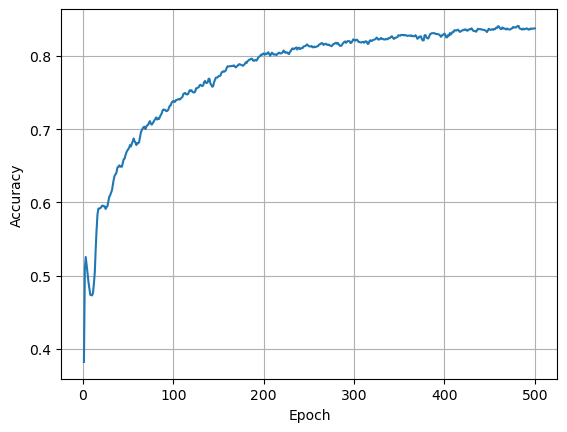

In [176]:
# 可视化
import matplotlib.pyplot as plt
import numpy as np

epoch = np.arange(1, len(acc_list) + 1, 1)
acc_list = np.array(acc_list)
plt.plot(epoch, acc_list)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid()
plt.show()

In [185]:
trainset